### install libraries 

In [ ]:
!pip install Keras-Applications


In [ ]:
! pip install imutils

### **`Extract digit numbers `**:

---



> first of all, we create  bounding boxes  and extract  4 groups of digit numbers and after that, we extract  each number from 4 groups of images and save   them  


### import libraries 

In [37]:
import cv2
import imutils
import argparse
import numpy as np
from imutils import contours
from matplotlib import pyplot as plt


In [38]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

In [66]:
image = cv2.imread("/content/drive/MyDrive/card.png")
image = imutils.resize(image, width=300)

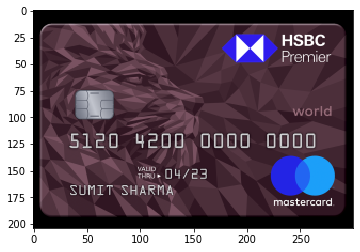

In [65]:
plt.imshow(image , interpolation='nearest')

In [67]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#it is useful in removing noise
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))

gradX = gradX.astype("uint8")
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []
for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if ar > 2.5 and ar < 4.0:
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            locs.append((x, y, w, h))
locs = sorted(locs, key=lambda x:x[0])
output = []

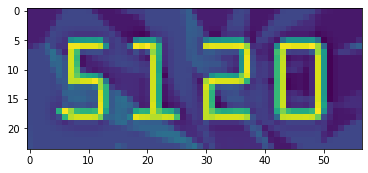

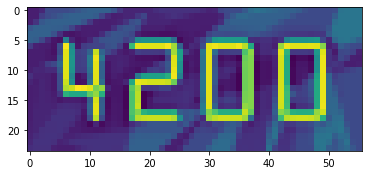

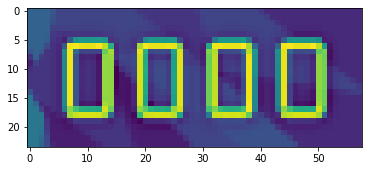

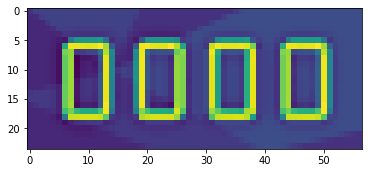

In [64]:
from PIL import Image
digit_num=0
lst=[]
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    groupOutput = []
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    plt.imshow(group, interpolation='nearest')
    plt.show()
 
    im = Image.fromarray(group)
    im.save("group"+str(digit_num)+".png")
    lst.append("group"+str(digit_num)+".png")
    digit_num+=1
    
   

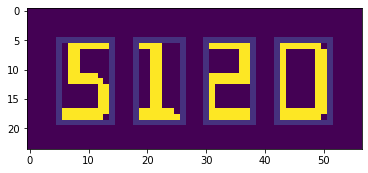

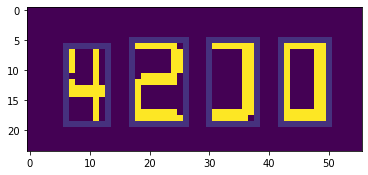

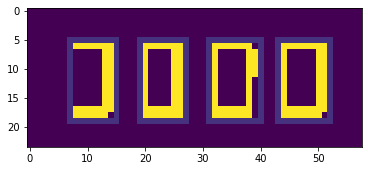

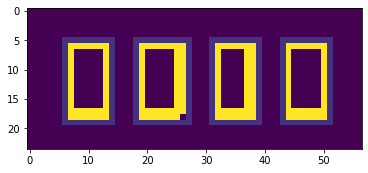

In [44]:
lst_digits_name=[]
for i in range(len(lst)):
  image = cv2.imread(lst[i])
  copy = image.copy()

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  if i==0:
      ROI_number = 1
  elif i==1:
      ROI_number = 5
  elif i==2:
      ROI_number =9
  else :
      ROI_number = 13

  for c in cnts:
      x,y,w,h = cv2.boundingRect(c)
      ROI = image[y:y+h, x:x+w]
      cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
      lst_digits_name.append('ROI_{}.png'.format(ROI_number))
      cv2.rectangle(thresh,(x,y),(x+w,y+h),(36,255,12),0)
      ROI_number += 1
  plt.imshow(thresh, interpolation='nearest')
  plt.show()

# for (i, (gX, gY, gW, gH)) in enumerate(thresh):
#     groupOutput = []
#     group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
#     plt.imshow(thresh, interpolation='nearest')
#     plt.show()

In [45]:
lst_digits_name

['ROI_1.png',
 'ROI_2.png',
 'ROI_3.png',
 'ROI_4.png',
 'ROI_5.png',
 'ROI_6.png',
 'ROI_7.png',
 'ROI_8.png',
 'ROI_9.png',
 'ROI_10.png',
 'ROI_11.png',
 'ROI_12.png',
 'ROI_13.png',
 'ROI_14.png',
 'ROI_15.png',
 'ROI_16.png']

### **`CNN`**

---

create our convolutional neural network 

*    transfer learning 
*  VGG16
*   99% accuracy 
*  884 datset with augmentation





In [4]:
!unzip /content/drive/MyDrive/CredCard.zip

Archive:  /content/drive/MyDrive/CredCard.zip
replace Credit Card Number Dataset/0/0_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.mobilenet_v2 import preprocess_input


In [6]:
data_dir = '/content/Credit Card Number Dataset'

In [8]:
file_path_all = list(glob.glob(data_dir+'/**/*.png'))

In [9]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path_all))
filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)


In [11]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [16]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

In [18]:
train_dataset = train_datagen.flow_from_dataframe(
                                            dataframe=train_df,
                                            x_col='Filepath',
                                            y_col='Label',
                                            target_size=(100, 100),
                                            rotation_range=30,
                                            zoom_range=0.15,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.15,
                                            horizontal_flip=True,
                                            fill_mode="nearest",
                                            shuffle=True,
                                            seed=0)
validation_dataset= train_datagen.flow_from_dataframe(
                                            dataframe=train_df,
                                            x_col='Filepath',
                                            y_col='Label',
                                            target_size=(100, 100),
                                            rotation_range=30,
                                            zoom_range=0.15,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.15,
                                            horizontal_flip=True,
                                            fill_mode="nearest",
                                            shuffle=True,
                                            seed=0)
test_dataset = test_datagen.flow_from_dataframe(
                                            dataframe=test_df,
                                            x_col='Filepath',
                                            y_col='Label',
                                            target_size=(100, 100))

Found 708 validated image filenames belonging to 10 classes.
Found 708 validated image filenames belonging to 10 classes.
Found 177 validated image filenames belonging to 10 classes.


In [20]:

pretrained_model = tf.keras.applications.VGG16(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)



In [21]:
pretrained_model.trainable = False

In [22]:
input = pretrained_model.input
x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=input, outputs=outputs)

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
callback = [EarlyStopping(monitor='val_accuracy',
                            min_delta=0,
                            patience=5,
                            mode='auto')]

In [26]:
history=model.fit(train_gen, validation_data=valid_gen, epochs=200, callbacks=callback)

Epoch 1/200
23/23 [==============================] - 12s 115ms/step - loss: 2.2314 - accuracy: 0.2062 - val_loss: 2.0448 - val_accuracy: 0.3305
Epoch 2/200
23/23 [==============================] - 2s 74ms/step - loss: 1.9101 - accuracy: 0.4040 - val_loss: 1.7105 - val_accuracy: 0.4703
Epoch 3/200
23/23 [==============================] - 2s 74ms/step - loss: 1.5556 - accuracy: 0.5353 - val_loss: 1.3668 - val_accuracy: 0.5862
Epoch 4/200
23/23 [==============================] - 2s 75ms/step - loss: 1.2722 - accuracy: 0.6229 - val_loss: 1.0926 - val_accuracy: 0.6949
Epoch 5/200
23/23 [==============================] - 2s 76ms/step - loss: 1.0335 - accuracy: 0.6850 - val_loss: 1.0101 - val_accuracy: 0.7062
Epoch 6/200
23/23 [==============================] - 2s 74ms/step - loss: 0.9082 - accuracy: 0.7218 - val_loss: 0.7837 - val_accuracy: 0.7627
Epoch 7/200
23/23 [==============================] - 2s 74ms/step - loss: 0.7706 - accuracy: 0.7853 - val_loss: 0.6873 - val_accuracy: 0.8432
Epoc

In [33]:
 model.save('credit_card_model.h5')

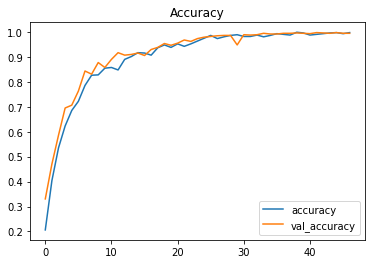

In [34]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

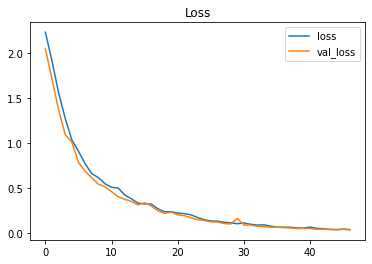

In [35]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

### **`predict`**



---
predict the list of  sorted number images (left to right)


In [36]:
my_model = tf.keras.models.load_model('credit_card_model.h5')


In [61]:
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(160, 160))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    return img_tensor
lst_predict=[]
if __name__ == "__main__":

    for i in range(len(lst_digits_name)):
      
         img_path = lst_digits_name[i]
         new_image = load_image(img_path)
         pred = model.predict(new_image)
         lst_predict.append(pred)
         

In [62]:
lst_predict

[array([[9.3285376e-01, 6.1869439e-05, 4.7776248e-06, 1.2360561e-03,
         9.3027724e-05, 8.8224243e-07, 2.7993100e-02, 1.1054815e-03,
         2.7164010e-02, 9.4871083e-03]], dtype=float32),
 array([[1.8299784e-01, 1.2200452e-02, 4.7246099e-04, 6.9220081e-02,
         6.0149478e-03, 3.7452488e-04, 1.1015974e-02, 4.7669705e-02,
         6.6137463e-01, 8.6593814e-03]], dtype=float32),
 array([[9.7543168e-01, 1.6382145e-04, 3.6705196e-06, 1.0458254e-03,
         2.9710027e-05, 7.7980951e-07, 6.7794663e-03, 4.1874227e-04,
         1.5607865e-02, 5.1842170e-04]], dtype=float32),
 array([[0.14771806, 0.00961165, 0.00177402, 0.02739379, 0.00070719,
         0.00175217, 0.5851296 , 0.17014153, 0.03581241, 0.01995952]],
       dtype=float32),
 array([[5.1794887e-01, 6.6571531e-04, 2.9709604e-06, 2.2125088e-04,
         3.6378310e-04, 1.3829286e-06, 4.2870986e-01, 5.4439233e-04,
         4.6088606e-02, 5.4532248e-03]], dtype=float32),
 array([[9.3109041e-01, 5.2189054e-05, 3.8548810e-06, 1.4